In [1]:
import json
import numpy as np
import os
import random
import pylab

from PIL import Image, ImageDraw

from matplotlib import pyplot as plt
from matplotlib import animation as animation

### Visualizing glimpses

In [2]:
def create_gif(img, pred, label, locs, patch_size, resize_factor, out_file):
    """Create GIF file with the sequence of glimpses produced by the model.

    Args:
        img (PIL Image): sample image
        pred (list): Predicted labels
        label (list): GT labels
        locs (list): Glimpse locations produced by the model
        patch_size (int): Size of the glimpses
        resize_factor (int): Resize factor for visualization
        out_file (str): Where to save the image and gif
    """
    # create draw object
    gif_image = img.copy()
    line_draw = ImageDraw.Draw(gif_image)

    frames = []
    for i in range(len(locs)):
        # get color for current glimpse
        point = locs[i]

        if i != 0:
            # All frames share the drawing of the line connecting glimpses
            line_draw.line((*prev_point, *point), fill="white")

        # In each frame only one glimpse will be visible, 
        frame = gif_image.copy()
        frame_draw = ImageDraw.Draw(frame)

        # draw center glimpse point
        frame_draw.point(point, fill="red")

        # draw an small circle around the center glimpse point (for better visibility)
        radius = 5
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        frame_draw.ellipse(shape, outline="red")

        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        frame_draw.rectangle(shape, outline="red")

        # update previous point
        prev_point = point
        
        # save frame
        frames.append(frame)

    # Set the initial frame
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], animated=True)
    ax.set_title(f"Prediction: {pred} | GT: {label}")
    ax.axis(False)

    def update(i):
        im.set_array(frames[i])
        return im

    # Create the animation (GIF)
    animation_fig = animation.FuncAnimation(
        fig, update, frames=len(frames), interval=400, blit=False, repeat_delay=200)
    animation_fig.save(out_file + ".gif")


def visualize_glimpses(sample, patch_size, save=False, out_file=None):
    """ Visualize sample results: Predictions and image/gif showing the glimpses taken
        by the model.
    
    Args:
        sample (dict): Sample results
        patch_size (int): Size of the glimpses
        save (bool): Wether to save the glimpse image/gif
        out_file (str): Where to save the image and gif

    Returns:
        PIL Image: Image containing all the glimpse            
    """
    pylab.ioff() # Prevent im.show() from showing all the images while running
    
    # load image and normalize
    img = np.array(sample["pixel_values"])
    img = (img * 0.3081) + 0.1307
    img = np.repeat(img, 3, axis=0)
    img = np.moveaxis(img, 0, 2)
    img = Image.fromarray(np.uint8(img*255))
    w, h = img.size
    
    # get prediction and GT labels
    pred, label = sample["pred"], sample["label"]

    # Resize to be visible
    resize_factor = 5
    img = img.resize((w*resize_factor, h*resize_factor))
    w, h = img.size

    # convert glimpse locations to pixel space
    locs = [[(i + 1)/2 * w, (j + 1)/2 * h] for i,j in sample["locs"]]

    # create draw object
    draw_img = img.copy()
    draw = ImageDraw.Draw(draw_img)

    for i in range(len(locs)):
        # draw center glimpse point
        point = locs[i]
        draw.point(point, fill="red")

        if i != 0:
            # Line joining past and current glimpse
            draw.line((*prev_point, *point), fill="white")

        # draw an small circle around the center glimpse point (for better visibility)
        radius = 5
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.ellipse(shape, outline="red")

        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.rectangle(shape, outline="red")

        # update previous point
        prev_point = point
    
    if save:
        # Save image
        fig, ax = plt.subplots()
        ax.imshow(draw_img)
        ax.set_title(f"Prediction: {pred} | GT: {label}")
        ax.axis(False)
        fig.savefig(out_file + ".png")
    
        # Create and save gif
        create_gif(img, pred, label, locs, patch_size, resize_factor, out_file)
    
    # Clean plots
    plt.close(fig)
    pylab.ion()
    
    return draw_img


In [3]:
#ckpt_dir = "/data/users/jmorales/model_files/RAM/baseline"
#ckpt_dir = "/data/users/jmorales/model_files/RAM/GPT2"
#ckpt_dir = "/data/users/jmorales/model_files/RAM/GTrXL"
ckpt_dir = "/data/users/jmorales/model_files/RAM/TrXL"

res_file = [i for i in os.listdir(ckpt_dir) if "results.json" in i][0]
res_file = os.path.join(ckpt_dir, res_file)

with open(res_file, "r") as f:
    results = json.load(f)

In [4]:
good = [i for i in results if i["pred"] == i["label"]]
bad = [i for i in results if i["pred"] != i["label"]]

/tmp/ipykernel_1303852/1531951184.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


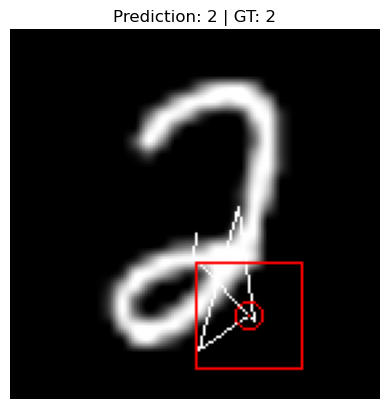

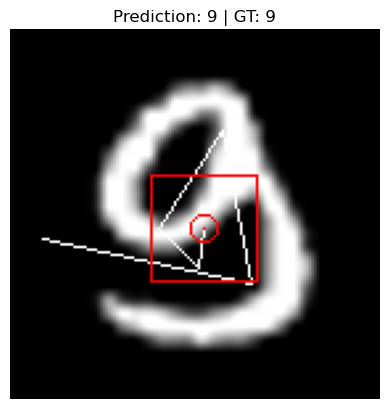

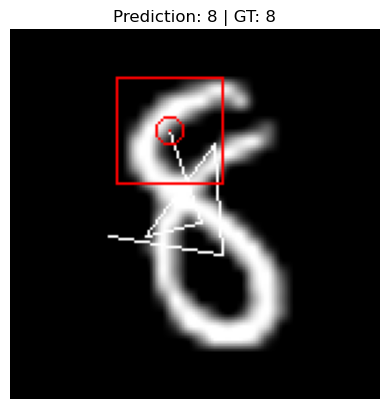

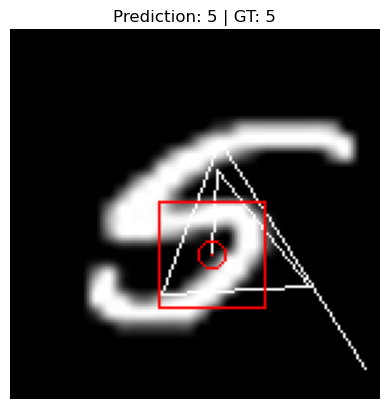

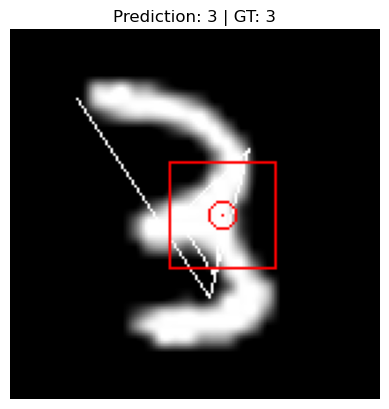

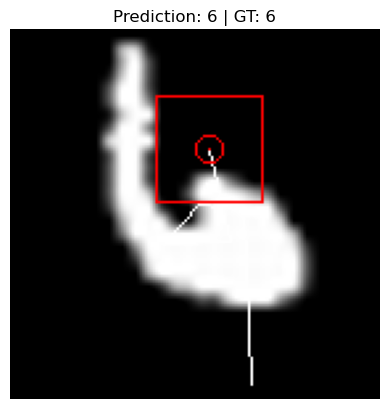

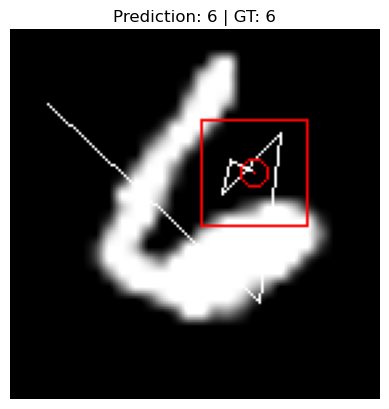

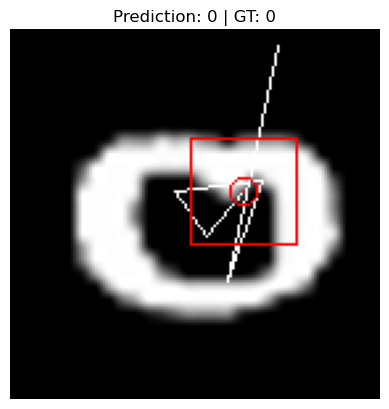

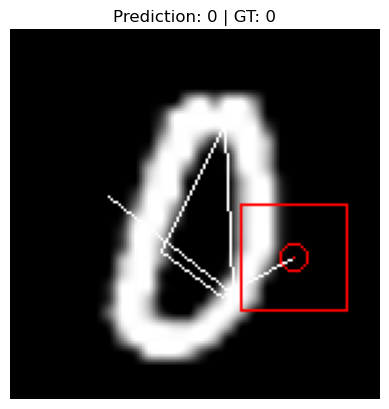

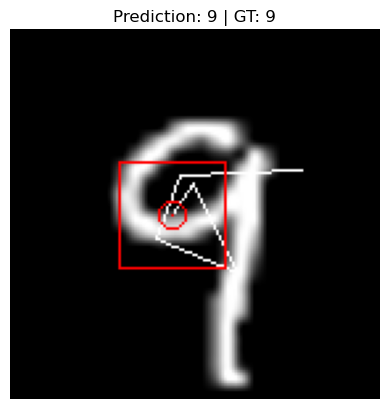

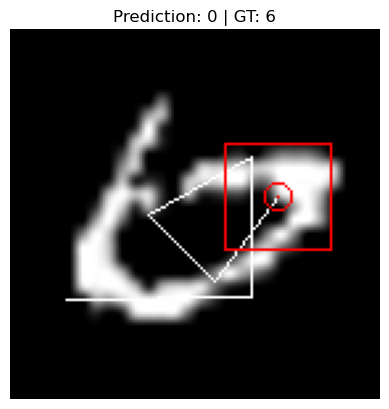

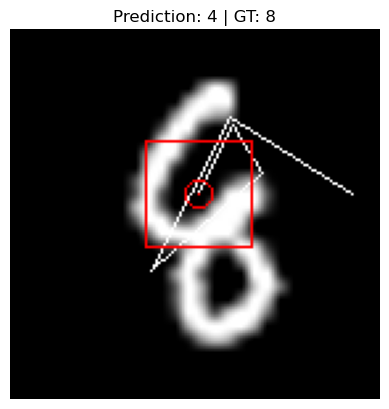

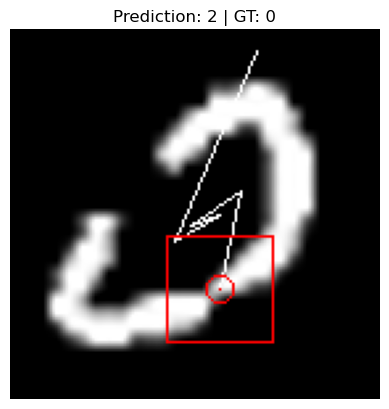

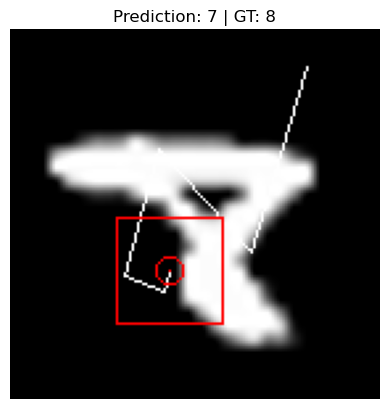

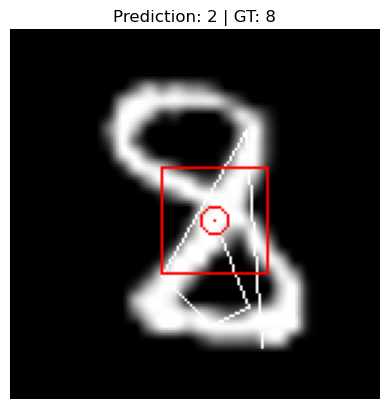

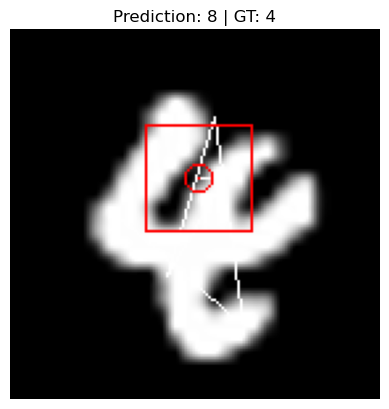

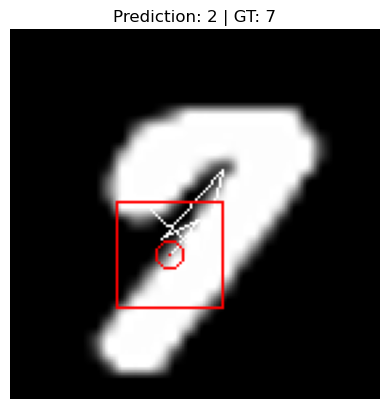

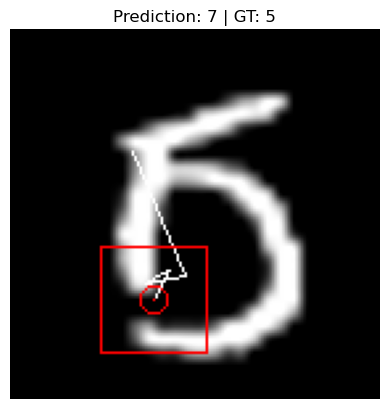

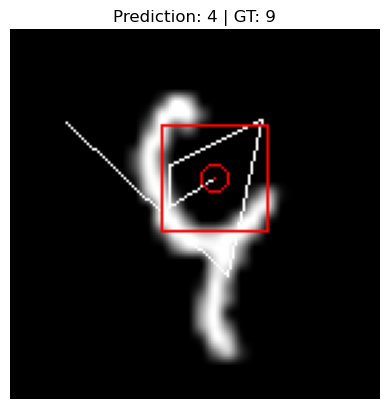

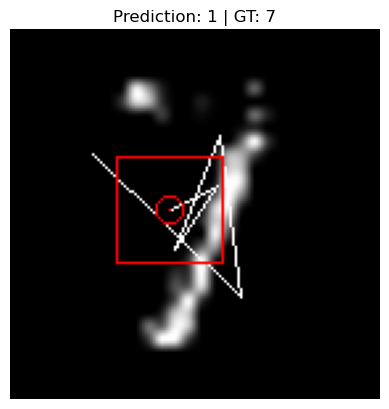

In [5]:
for samples, label in zip([good, bad], ["correct", "wrong"]):
    samples = random.sample(samples, 10)
    for i, sample in enumerate(samples):
        visualize_glimpses(
            sample, 
            patch_size=8,
            save=True, 
            out_file=f"../plots/Experiment1/TrXL_{label}_{i}"
            )